### Convolutional neural networks (CNN) approach for Breast Cancer diagnosis using histological data

- Model implemented using Pytorch
- Model tested on Google Cloud instance running 1x NVDIA K80 GPU
- ICIAR2018 Challenge dataset (400 RGB images in total): https://iciar2018-challenge.grand-challenge.org
- 4 distinct classes (Normal, Invasise, InSitu, Beningn)
- 93% accuracy achieved on the test set

In [37]:
# Import modules

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from data_utils import getFileList, sortTarget
from PIL import Image
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import np
import time
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [38]:
## PARAMETERS
path = '/home/goncalochavesf/iciar2018/ICIAR2018_BACH_Challenge/Photos/'
im_type = '.tif'
perc = 0.2 # percentage of image for testing
batch_sz = 24

#[1536x2048x3]
#==============================================================================
# GET IMAGE LIST AND INFO
#==============================================================================
im_folder = np.array(getFileList(path,im_type)) # image list
# Load csv with image information
im_info = pd.read_csv(getFileList(path,'.csv')[0], header = None)
im_info.columns = ['filename','target']

# # =============================================================================
# MATCH IMAGE LIST AND LABELS
# =============================================================================
im_info = sortTarget(im_folder,im_info)
le = preprocessing.LabelEncoder()
T = im_info.target
T = np.array(le.fit_transform(T))

# Train/Test Split
split = StratifiedShuffleSplit(n_splits = 1, test_size = perc, random_state = 0)
for train_index, test_index in split.split(im_folder,T):          
    train_files = train_index
    test_files =  test_index
    
del im_info, le, train_index, test_index, split

In [39]:
# Defining data loader for multiple worker threads

class ICIARDataset(Dataset):
       
    def __init__(self,img_path,csv_path,idx, transform = None):
        
        self.img_path = img_path
        self.img_info = csv_path
        self.transform = transform
        self.X = img_path[idx]
        self.y = csv_path[idx]
            
    def __getitem__(self,index):
        
        img = Image.open(self.X[index]) 
        img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(np.asarray(self.y[index]).reshape([1]))
        
        return img,label
    
    def __len__(self):
        return len(self.X)

transformations = transforms.Compose(
     [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        
data_train = ICIARDataset(im_folder,T, train_files, transformations)
data_test = ICIARDataset(im_folder,T, test_files, transformations)

train_loader = DataLoader(data_train, batch_size=batch_sz, shuffle=True, num_workers=2)
test_loader = DataLoader(data_test, batch_size=batch_sz, shuffle=False, num_workers=2)
del data_train, data_test

In [40]:
# Define network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # [vol depth x n_filters x filter_size]
        self.conv1 = nn.Conv2d(3, 20, 2, stride=2, padding=0)   
        self.conv1_bn = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(4, 4)
        
        self.conv2 = nn.Conv2d(20, 30, 2, stride=2, padding=0)
        self.conv2_bn = nn.BatchNorm2d(30)
        self.pool2 = nn.MaxPool2d(4, 4)

        self.fc1 = nn.Linear(24 * 32 * 30, 500)
        self.fc2 = nn.Linear(500, 120)
        self.fc3 = nn.Linear(120, 4)

    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 24 * 32 * 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

model = Net()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(model)

Net(
  (conv1): Conv2d(3, 20, kernel_size=(2, 2), stride=(2, 2))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (pool1): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(20, 30, kernel_size=(2, 2), stride=(2, 2))
  (conv2_bn): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True)
  (pool2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=23040, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)


In [41]:
# Train/Test function

def train(epoch):
    
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.view(-1)
 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        
    return running_loss / i

def test(epoch):

    model.eval()
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = Variable(images.cuda(), volatile=True)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = np.squeeze(labels).cuda()
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    train_score = (100 * correct / total)
    
    for images, labels in test_loader:
        images = Variable(images.cuda(), volatile=True)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = np.squeeze(labels).cuda()
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    test_score = (100 * correct / total)
    
    return train_score, test_score

[epoch 1] loss: 1.962 Train: 38% Test: 39%
[epoch 2] loss: 1.438 Train: 50% Test: 48%
[epoch 3] loss: 1.158 Train: 53% Test: 52%
[epoch 4] loss: 1.057 Train: 56% Test: 55%
[epoch 5] loss: 1.183 Train: 68% Test: 65%
[epoch 6] loss: 0.848 Train: 66% Test: 64%
[epoch 7] loss: 0.785 Train: 74% Test: 70%
[epoch 8] loss: 0.826 Train: 80% Test: 77%
[epoch 9] loss: 0.754 Train: 84% Test: 80%
[epoch 10] loss: 0.555 Train: 67% Test: 64%
[epoch 11] loss: 0.764 Train: 74% Test: 73%
[epoch 12] loss: 0.531 Train: 94% Test: 88%
[epoch 13] loss: 0.334 Train: 96% Test: 91%
[epoch 14] loss: 0.300 Train: 94% Test: 87%
[epoch 15] loss: 0.220 Train: 98% Test: 91%
[epoch 16] loss: 0.138 Train: 99% Test: 93%
[epoch 17] loss: 0.150 Train: 99% Test: 93%
[epoch 18] loss: 0.081 Train: 99% Test: 92%
[epoch 19] loss: 0.077 Train: 100% Test: 93%
[epoch 20] loss: 0.027 Train: 100% Test: 93%
[epoch 21] loss: 0.026 Train: 100% Test: 92%
[epoch 22] loss: 0.026 Train: 100% Test: 93%
[epoch 23] loss: 0.047 Train: 100% Te

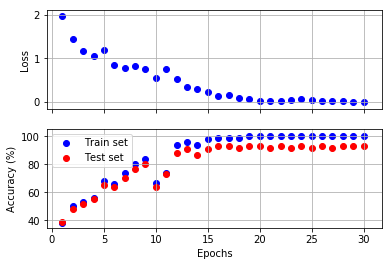

In [42]:
t1 = time.time()
f, axarr = plt.subplots(2, sharex=True)

for epoch in range(30):
    t_loss = train(epoch)
    train_score, test_score = test(epoch)
    
    print('[epoch %d] loss: %.3f Train: %d%% Test: %d%%' % (epoch + 1, t_loss,train_score,test_score))

    axarr[0].scatter(epoch+1, t_loss,color='blue')
    axarr[0].grid(True)
    axarr[0].set_ylabel('Loss')
    axarr[1].scatter(epoch+1, train_score, color = 'blue',label = 'Train set')
    axarr[1].scatter(epoch+1, test_score, color = 'red', label = 'Test set')
    axarr[1].grid(True)
    axarr[1].set_xlabel('Epochs')
    axarr[1].set_ylabel('Accuracy (%)')        
    if epoch == 0:
        axarr[1].legend()

        
        
elapsed2 = time.time() - t1
print(elapsed2, ' seconds')   
